In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*`torch.cuda.amp.autocast.*")
import torch
import numpy as np
import random
import PIL.Image
import matplotlib.pyplot as plt
from types import SimpleNamespace
from datasets import load_dataset
from timm.optim import Mars
from torchvision.transforms.v2 import (
    Compose, Resize, RandomCrop, CenterCrop,
    PILToTensor, ToPILImage, CutMix, MixUp )
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import display, HTML

In [2]:
torch.set_float32_matmul_precision('high')
device = "cuda:2"
dataset_train = load_dataset('timm/imagenet-1k-wds',split='train')
dataset_valid = load_dataset('timm/imagenet-1k-wds',split='validation')

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/292 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

In [3]:
config = SimpleNamespace()
# Training and optimizer config
config.batch_size = 128
config.steps_per_epoch = dataset_train.num_rows//config.batch_size
config.grad_accum_steps = 1
config.max_lr = (config.batch_size/128)*6e-4
config.min_lr = config.max_lr/100
config.plot_update = 128
config.epochs = 400
config.lr_scale = 1.6
config.lr_offset = 0.25
config.lr_pow = 6
config.weight_decay = 0.0
config.num_workers = 16
config.crop_size = 256

# model config
config.channels = 3
config.classifier_num_classes = 1000
config.checkpoint = False

In [4]:
from timm.models.vision_transformer import VisionTransformer
import einops
class Classifier2D(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.s1 = VisionTransformer(
            num_classes=0,
            img_size=config.crop_size,
            patch_size=16,
            in_chans=config.channels,
            embed_dim=256,
            depth=4,
            num_heads=4,
            mlp_ratio=4.,
            reg_tokens=1,
            global_pool='avg',
            class_token=False,
            no_embed_class=True,
            init_values=1e-5
        )
        self.s2 = VisionTransformer(
            num_classes=0,
            img_size=config.crop_size//16,
            patch_size=2,
            in_chans=256,
            embed_dim=384,
            depth=4,
            num_heads=6,
            mlp_ratio=3.,
            reg_tokens=1,
            global_pool='avg',
            class_token=False,
            no_embed_class=True,
            init_values=1e-5
        )
        self.s3 = VisionTransformer(
            num_classes=config.classifier_num_classes,
            img_size=config.crop_size//32,
            patch_size=2,
            in_chans=384,
            embed_dim=512,
            depth=4,
            num_heads=8,
            mlp_ratio=2.,
            reg_tokens=1,
            global_pool='avg',
            class_token=False,
            no_embed_class=True,
            init_values=1e-5
        )

    def forward(self,x):
        x = self.s1.forward_features(x)
        x = einops.rearrange(x[:,1:,:],'b (h w) c -> b c h w', h=16,w=16)
        x = self.s2.forward_features(x)
        x = einops.rearrange(x[:,1:,:],'b (h w) c -> b c h w', h=8,w=8)
        x = self.s3(x)
        return x

model = Classifier2D(config).to(device)

for name, module in model.named_children():
    print(f"{sum(p.numel() for p in module.parameters())/1e6} \t {name}")

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint, map_location="cpu", weights_only=False)
    model.load_state_dict(checkpoint['model'])

3.424256 	 s1
6.339072 	 s2
9.724904 	 s3


In [5]:
mix_transforms = [
    CutMix(num_classes=config.classifier_num_classes, alpha=1.),
    MixUp(num_classes=config.classifier_num_classes, alpha=1.)
]

def get_size(h=288,w=384,scale=(0.05, 1.95),ratio=(0.75, 1.25)):
    orig_area = w * h
    scale = (scale[1]-scale[0])*torch.rand(1).item()+scale[0]
    ratio = (ratio[1]-ratio[0])*torch.rand(1).item()+ratio[0]
    target_area = scale * orig_area
    w = int(round((target_area / ratio)**0.5))
    h = int(round(ratio * w))
    return (h,w)
    
rand_crop = lambda h,w : Compose([
    RandomCrop(
        get_size(h,w),
        pad_if_needed=True,
        padding_mode='reflect'
    ),
    Resize(
        (config.crop_size,config.crop_size),
        interpolation=PIL.Image.Resampling.LANCZOS
    ),
    PILToTensor()
])

cent_crop = Compose([
    CenterCrop(
        size=config.crop_size,
    ),
    PILToTensor()
])


def train_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.crop_size, config.crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['cls']
        rc = rand_crop(
            h = sample['jpg'].height,
            w = sample['jpg'].width
        )
        x[i_sample,:,:,:] = rc(sample['jpg'].convert("RGB"))
    x = x.to(torch.float)/255
    x = x - 0.5
    x = 2*x
    y = y.to(torch.long)
    return x, y

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.crop_size, config.crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['cls']
        x[i_sample,:,:,:] = cent_crop(sample['jpg'].convert("RGB"))
    x = x.to(torch.float)/255
    x = x - 0.5
    x = 2*x
    y = y.to(torch.long)
    return (x,y)

In [6]:
optimizer = Mars(
    params=model.parameters(),
    lr=config.min_lr,
    weight_decay=config.weight_decay,
    caution=True
)

def EmPL(x):
    return np.exp(-np.power(np.log(x), config.lr_pow))
        
def EmPL_sched(i_step, config):
    x = i_step / (config.steps_per_epoch/config.plot_update)
    sched = EmPL(x/(config.lr_scale*config.steps_per_epoch/config.plot_update)+config.lr_offset)
    scale = config.max_lr
    lr = scale * sched
    return lr / config.min_lr
    
schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: EmPL_sched(i_step, config),
)

/home/dgj335/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


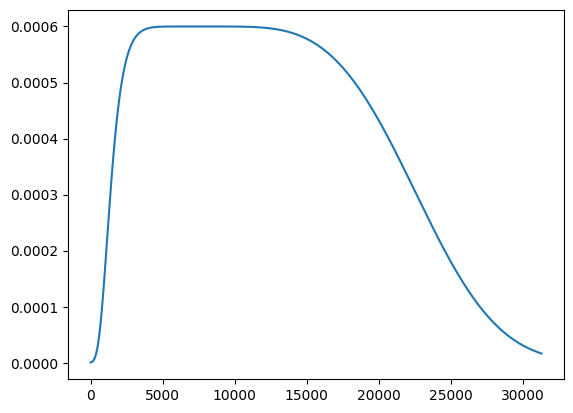

In [7]:
# learning_rates = [optimizer.param_groups[0]['lr']]
# i_step = 0
# for i_epoch in range(config.epochs):
#     for i_batch in range(config.steps_per_epoch):
#         if (i_step+1) % config.plot_update == 0:
#             schedule.step()
#             learning_rates.append(optimizer.param_groups[0]['lr'])
#         i_step+=1
# import matplotlib.pyplot as plt
# plt.plot(learning_rates)

/home/dgj335/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


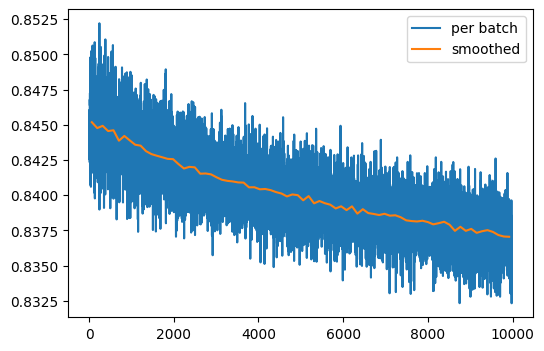

/home/dgj335/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:714: UserWarning: Metadata Warning, tag 274 had too many entries: 4, expected 1
  warnings.warn(
/home/dgj335/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/dgj335/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/home/dgj335/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/home/dgj335/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:714: UserWarning: Metadata Warning, tag 274 had too many entries: 4, expected 1
  warnings.warn(
/home/dgj335/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to re

In [ ]:
mb = master_bar(range(config.epochs))
mb.names = ['per batch','smoothed']
train_loss = []
valid_acc = []
learning_rates = [optimizer.param_groups[0]['lr']]
i_step = 0
for i_epoch in mb:
    # training
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=train_collate_fn
    )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, (x,y) in enumerate(pb):
        y = y.to(torch.long).to(device)
        x = x.to(device)
        for mix_transform in mix_transforms:
            x, y = mix_transform(x, y) 

        logits = model(x)
        loss = torch.nn.CrossEntropyLoss()(input=logits, target=y)

        train_loss.append(loss.item())
        loss.backward()
        if (i_batch + 1) % config.grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # plotting and learning rate update
        if (i_step+1) % config.plot_update == 0:
            plot_n = len(train_loss) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(train_loss).reshape(plot_n, -1).mean(dim=1)
            train_x = range(len(train_loss))
            train_y = train_loss
            mb.update_graph([[train_x, np.log10(train_y)],[smoothed_x, np.log10(smoothed_y)]])

            # lr update
            schedule.step()
            learning_rates.append(optimizer.param_groups[0]['lr'])
    
        i_step+=1
        
    # validation
    model.eval()
    valid_acc.append(0)
    data_loader_valid = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    pb_valid = progress_bar(data_loader_valid, parent=mb)
    for i_batch, (x, y) in enumerate(pb_valid):
        y = y.to(device)
        x = x.to(device)
        with torch.no_grad():
            logits = model(x)
        valid_acc[i_epoch] += torch.sum(logits.argmax(dim=1) == y).item()
    valid_acc[i_epoch] /= len(dataset_valid)
    
    mb.main_bar.comment = f'valid_acc {valid_acc[i_epoch]:.4g}'
    
    torch.save({
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'smoothed_y': smoothed_y,
        'valid_acc': valid_acc,
        'config': config,
        'model_state_dict': model.state_dict(),
    }, f"log_g_{device}.pth")

In [ ]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

In [ ]:
plt.plot(valid_acc)

In [ ]:
plt.semilogy(learning_rates)

In [ ]:
plt.semilogy(smoothed_y)
plt.ylim([0,7])

In [ ]:
# torch.save({
#     'i_epoch': i_epoch,
#     'learning_rates': learning_rates,
#     'smoothed_y': smoothed_y,
#     'valid_acc': valid_acc,
#     'config': config,
#     'model': model.state_dict(),
# }, f"../../hf/tft/tft_wptdrop_v0.1.pth")